# Feature tracking with autoRIFT
Quinn Brencher

some code from: https://github.com/parosen/Geo-SInC/blob/main/UNAVCO2021/4.4_Offset_stack_for_velocity_dynamics/nb_topsApp_offsets.ipynb

In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
import matplotlib
import numpy as np
import os
from autoRIFT import autoRIFT
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
import seaborn as sns
import pystac
import pystac_client
import stackstac
from dask.distributed import Client
import geopandas as gpd
from shapely.geometry import shape
import dask

## query to find appropriate dates

In [2]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

In [3]:
# handy -> https://geojson.io/#map=2/0/20
bbox = {
    "type": "Polygon",
    "coordinates": [
          [
            [75.42382800808971,36.41082887114753],
            [75.19442677164156,36.41082887114753],
            [75.19442677164156,36.201076360872946],
            [75.42382800808971,36.201076360872946],
            [75.42382800808971,36.41082887114753]
          ]
        ],
}

In [4]:
# We use the api from element84 to query the data
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

In [5]:
time_of_interest = "2015-06-27/2024-05-27"

In [6]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=bbox,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}}, # less than 10% cloud cover
)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 182 Items


In [7]:
sentinel2_stack = stackstac.stack(items)

/srv/conda/envs/image-correlation/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [8]:
# select images from May-September to minimize snow cover
sentinel2_stack_snowoff = sentinel2_stack.where((sentinel2_stack.time.dt.month > 5) & (sentinel2_stack.time.dt.month < 10), drop=True)

In [9]:
sentinel2_stack_snowoff.time

<xarray.DataArray 'time' (time: 42)> Size: 336B
array(['2018-06-02T05:48:52.001000000', '2018-06-07T05:48:55.115000000',
       '2018-07-15T05:47:01.712000000', '2018-08-04T05:58:46.950000000',
       '2018-09-18T05:58:46.342000000', '2019-07-05T05:58:55.905000000',
       '2019-09-28T05:58:51.137000000', '2020-06-29T05:58:56.137000000',
       '2020-07-24T05:58:53.088000000', '2020-07-29T05:58:56.644000000',
       '2020-08-23T05:58:54.431000000', '2020-08-25T05:48:59.672000000',
       '2020-08-25T05:48:59.672000000', '2020-08-25T05:49:06.328000000',
       '2020-08-25T05:49:06.330000000', '2020-09-22T05:58:53.184000000',
       '2021-06-06T05:48:56.212000000', '2021-06-09T05:58:52.014000000',
       '2021-09-02T05:58:52.038000000', '2021-09-04T05:48:51.650000000',
       '2021-09-07T05:58:47.381000000', '2021-09-07T05:58:47.384000000',
       '2021-09-09T05:48:55.260000000', '2021-09-09T05:48:55.260000000',
       '2021-09-19T05:48:57.542000000', '2021-09-27T05:58:49.654000000',
       '2021-09-29T05:48:59.358000000', '2022-06-24T05:58:55.826000000',
       '2022-07-01T05:49:00.353000000', '2022-07-04T05:58:56.068000000',
       '2022-07-19T05:59:02.743000000', '2022-07-21T05:49:00.168000000',
       '2022-09-19T05:48:56.770000000', '2022-09-27T05:58:58.195000000',
       '2022-09-29T05:48:54.960000000', '2023-06-19T05:58:55.437000000',
       '2023-06-21T05:49:02.713000000', '2023-06-24T05:58:54.163000000',
       '2023-07-14T05:58:55.968000000', '2023-08-13T05:58:56.079000000',
       '2023-08-30T05:49:00.610000000', '2023-09-12T05:58:55.693000000'],
      dtype='datetime64[ns]')
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 336B 2018-...
    id                                       (time) <U24 4kB 'S2B_43SEA_20180...
    mgrs:latitude_band                       <U1 4B 'S'
    s2:medium_proba_clouds_percentage        (time) float64 336B 1.58 ... 0.0...
    earthsearch:s3_path                      (time) <U80 13kB 's3://sentinel-...
    processing:software                      (time) object 336B {'sentinel2-t...
    ...                                       ...
    s2:granule_id                            (time) <U62 10kB 'S2B_OPER_MSI_L...
    earthsearch:payload_id                   (time) <U74 12kB 'roda-sentinel2...
    eo:cloud_cover                           (time) float64 336B 3.218 ... 0....
    earthsearch:boa_offset_applied           (time) bool 42B True True ... True
    s2:mgrs_tile                             (time) object 336B None ... None
    epsg                                     int64 8B 32643

## download data from selected dates 

In [10]:
img1_date = '2022-06-24'
img2_date = '2022-09-27'

In [11]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=bbox,
    datetime=img1_date,
    query={"eo:cloud_cover": {"lt": 10}}, # less than 10% cloud cover
)

# Check how many items were returned
items = search.item_collection()
img1_full = stackstac.stack(items)

/srv/conda/envs/image-correlation/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [12]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=bbox,
    datetime=img2_date,
    query={"eo:cloud_cover": {"lt": 10}}, # less than 10% cloud cover
)

# Check how many items were returned
items = search.item_collection()
img2_full = stackstac.stack(items)

/srv/conda/envs/image-correlation/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [13]:
aoi = gpd.GeoDataFrame({'geometry':[shape(bbox)]})
# crop images to aoi
img1_clipped = img1_full.rio.clip_box(*aoi.total_bounds,crs=4326) 
img2_clipped = img2_full.rio.clip_box(*aoi.total_bounds,crs=4326) 

In [14]:
img1_ds = img1_clipped.to_dataset(dim='band')
img1 = img1_ds.nir.squeeze().values
img2_ds = img2_clipped.to_dataset(dim='band')
img2 = img2_ds.nir.squeeze().values

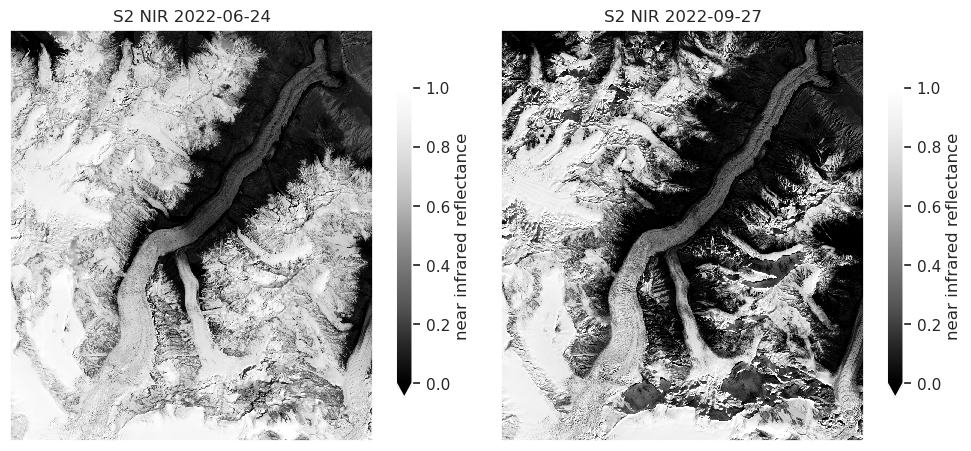

In [15]:
# plot images
sns.set_theme()
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
img1_ds.nir.plot(ax=ax[0], vmin=0, vmax=1, cmap='Greys_r', cbar_kwargs= {'shrink':0.7, 'label':'near infrared reflectance'})
img2_ds.nir.plot(ax=ax[1], vmin=0, vmax=1, cmap='Greys_r', cbar_kwargs= {'shrink':0.7, 'label':'near infrared reflectance'})
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_title(f'S2 NIR {img1_ds.isel(time=0).time.dt.strftime('%Y-%m-%d').item()}')
ax[1].set_title(f'S2 NIR {img2_ds.isel(time=0).time.dt.strftime('%Y-%m-%d').item()}')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
f.tight_layout()

In [16]:
def run_autoRIFT(img1, img2, skip_x=3, skip_y=3, min_x_chip=16, max_x_chip=64,
                 preproc_filter_width=3, mpflag=4, search_limit_x=30, search_limit_y=30):
        
    obj = autoRIFT()
    # obj.configure()
    obj.MultiThread = mpflag

    obj.I1 = img1
    obj.I2 = img2

    obj.SkipSampleX = skip_x
    obj.SkipSampleY = skip_y

    # Kernel sizes to use for correlation
    obj.ChipSizeMinX = min_x_chip
    obj.ChipSizeMaxX = max_x_chip
    obj.ChipSize0X = min_x_chip
    # oversample ratio, balancing precision and performance for different chip sizes
    obj.OverSampleRatio = {obj.ChipSize0X:16, obj.ChipSize0X*2:32, obj.ChipSize0X*4:64}

    # generate grid
    m,n = obj.I1.shape
    xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
    yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY)
    nd = xGrid.__len__()
    md = yGrid.__len__()
    obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
    obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
    noDataMask = np.invert(np.logical_and(obj.I1[:, xGrid-1][yGrid-1, ] > 0, obj.I2[:, xGrid-1][yGrid-1, ] > 0))

    # set search limits
    obj.SearchLimitX = np.full_like(obj.xGrid, search_limit_x)
    obj.SearchLimitY = np.full_like(obj.xGrid, search_limit_y)

    # set search limit and offsets in nodata areas
    obj.SearchLimitX = obj.SearchLimitX * np.logical_not(noDataMask)
    obj.SearchLimitY = obj.SearchLimitY * np.logical_not(noDataMask)
    obj.Dx0 = obj.Dx0 * np.logical_not(noDataMask)
    obj.Dy0 = obj.Dy0 * np.logical_not(noDataMask)
    obj.Dx0[noDataMask] = 0
    obj.Dy0[noDataMask] = 0
    obj.NoDataMask = noDataMask

    print("preprocessing")
    obj.WallisFilterWidth = preproc_filter_width
    obj.preprocess_filt_lap()
    obj.uniform_data_type()

    print("starting autoRIFT")
    obj.runAutorift()
    print("autoRIFT complete")

    # convert displacement to m
    obj.Dx_m = obj.Dx * 10
    obj.Dy_m = obj.Dy * 10
        
    return obj

In [27]:
# scale search limit with temporal baseline
search_limit_x = search_limit_y = round(((((img2_ds.time.isel(time=0) - img1_ds.time.isel(time=0)).dt.days)*100)/365.25).item())

In [17]:
%%time
obj = run_autoRIFT(img1, img2, search_limit_x=search_limit_x, search_limit_y=search_limit_y)

# interpolate to original dimensions 
x_coords = obj.xGrid[0, :]
y_coords = obj.yGrid[:, 0]

# Create a mesh grid for the img dimensions
x_coords_new, y_coords_new = np.meshgrid(
    np.arange(obj.I2.shape[1]),
    np.arange(obj.I2.shape[0])
)

# Perform bilinear interpolation using scipy.interpolate.interpn
Dx_full = interpn((y_coords, x_coords), obj.Dx, (y_coords_new, x_coords_new), method="linear", bounds_error=False)
Dy_full = interpn((y_coords, x_coords), obj.Dy, (y_coords_new, x_coords_new), method="linear", bounds_error=False)
Dx_m_full = interpn((y_coords, x_coords), obj.Dx_m, (y_coords_new, x_coords_new), method="linear", bounds_error=False)
Dy_m_full = interpn((y_coords, x_coords), obj.Dy_m, (y_coords_new, x_coords_new), method="linear", bounds_error=False)

# add variables to img1 dataset
img1_ds = img1_ds.assign({'Dx':(['y', 'x'], Dx_full),
                          'Dy':(['y', 'x'], Dy_full),
                          'Dx_m':(['y', 'x'], Dx_m_full),
                          'Dy_m':(['y', 'x'], Dy_m_full)})
# calculate x and y velocity
img1_ds['veloc_x'] = (img1_ds.Dx_m/(img2_ds.time.isel(time=0) - img1_ds.time.isel(time=0)).dt.days)*365.25
img1_ds['veloc_y'] = (img1_ds.Dy_m/(img2_ds.time.isel(time=0) - img1_ds.time.isel(time=0)).dt.days)*365.25

# calculate total horizontal velocity
img1_ds['veloc_horizontal'] = np.sqrt(img1_ds['veloc_x']**2 + img1_ds['veloc_y']**2)

preprocessing


/srv/conda/envs/image-correlation/lib/python3.12/site-packages/autoRIFT/autoRIFT.py:341: RuntimeWarning: divide by zero encountered in log10
  self.I1 = 20.0 * np.log10(self.I1)
/srv/conda/envs/image-correlation/lib/python3.12/site-packages/autoRIFT/autoRIFT.py:341: RuntimeWarning: invalid value encountered in log10
  self.I1 = 20.0 * np.log10(self.I1)
/srv/conda/envs/image-correlation/lib/python3.12/site-packages/autoRIFT/autoRIFT.py:344: RuntimeWarning: divide by zero encountered in log10
  self.I2 = 20.0 * np.log10(self.I2)
/srv/conda/envs/image-correlation/lib/python3.12/site-packages/autoRIFT/autoRIFT.py:344: RuntimeWarning: invalid value encountered in log10
  self.I2 = 20.0 * np.log10(self.I2)
/srv/conda/envs/image-correlation/lib/python3.12/site-packages/autoRIFT/autoRIFT.py:363: RuntimeWarning: invalid value encountered in cast
  self.I1 = np.round(np.clip(self.I1, 0, 255)).astype(np.uint8)
/srv/conda/envs/image-correlation/lib/python3.12/site-packages/autoRIFT/autoRIFT.py:376

starting autoRIFT


/srv/conda/envs/image-correlation/lib/python3.12/site-packages/autoRIFT/autoRIFT.py:1826: RuntimeWarning: divide by zero encountered in divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2
/srv/conda/envs/image-correlation/lib/python3.12/site-packages/autoRIFT/autoRIFT.py:1827: RuntimeWarning: divide by zero encountered in divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2
/srv/conda/envs/image-correlation/lib/python3.12/site-packages/autoRIFT/autoRIFT.py:1774: RuntimeWarning: All-NaN slice encountered
  D = np.nanmedian(B, axis=0)
/srv/conda/envs/image-correlation/lib/python3.12/site-packages/autoRIFT/autoRIFT.py:1777: RuntimeWarning: All-NaN slice encountered
  C = np.nanmedian(D, axis=0, overwrite_input=True)
/srv/conda/envs/image-correlation/lib/python3.12/site-packages/autoRIFT/autoRIFT.py:1764: RuntimeWarning: All-NaN slice encountered
  C = np.nanmedian(B, axis=0, overwrite_input=True)
/srv/conda/envs/image-correlation/lib/python3.12

autoRIFT complete
CPU times: user 24.6 s, sys: 748 ms, total: 25.4 s
Wall time: 2min 6s


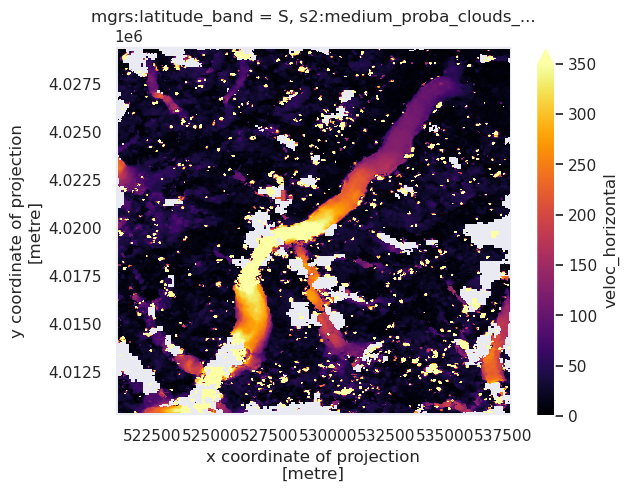

In [18]:
img1_ds.veloc_horizontal.plot(vmin=0, vmax=350, cmap='inferno')